# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# Load the data
house_data = pd.read_csv('./data/pierce_county_house_sales.csv')

# Initial exploration
print(house_data.head())
print(house_data.info())
print(house_data.describe())

    sale_date  sale_price  house_square_feet  attic_finished_square_feet  \
0  2020-01-02      380000               2157                           0   
1  2020-01-02      383000               2238                           0   
2  2020-01-01      419900               1452                           0   
3  2020-01-02      251660                832                           0   
4  2020-01-02      500000               1780                           0   

   basement_square_feet  attached_garage_square_feet  \
0                     0                          528   
1                     0                          396   
2                     0                            0   
3                     0                            0   
4                   384                          484   

   detached_garage_square_feet  fireplaces        hvac_description  \
0                            0           0  Warm and Cool Air Zone   
1                            0           0              Forced Air

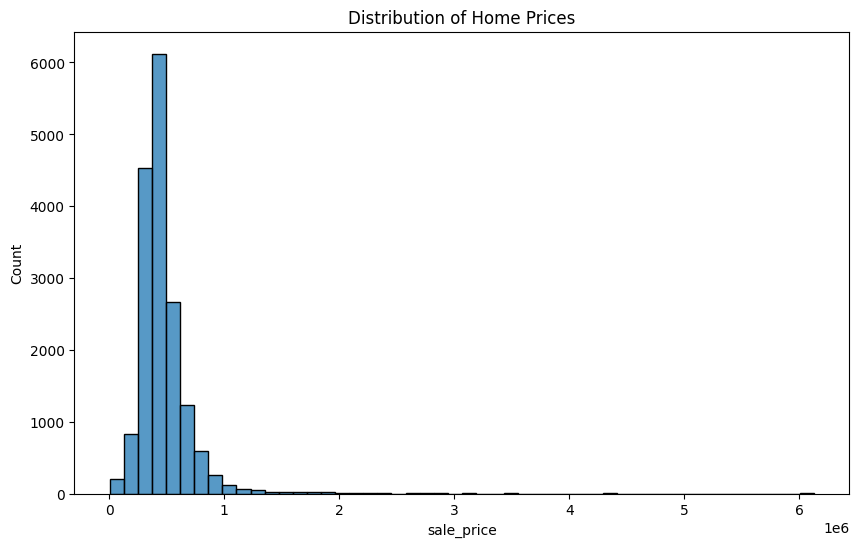

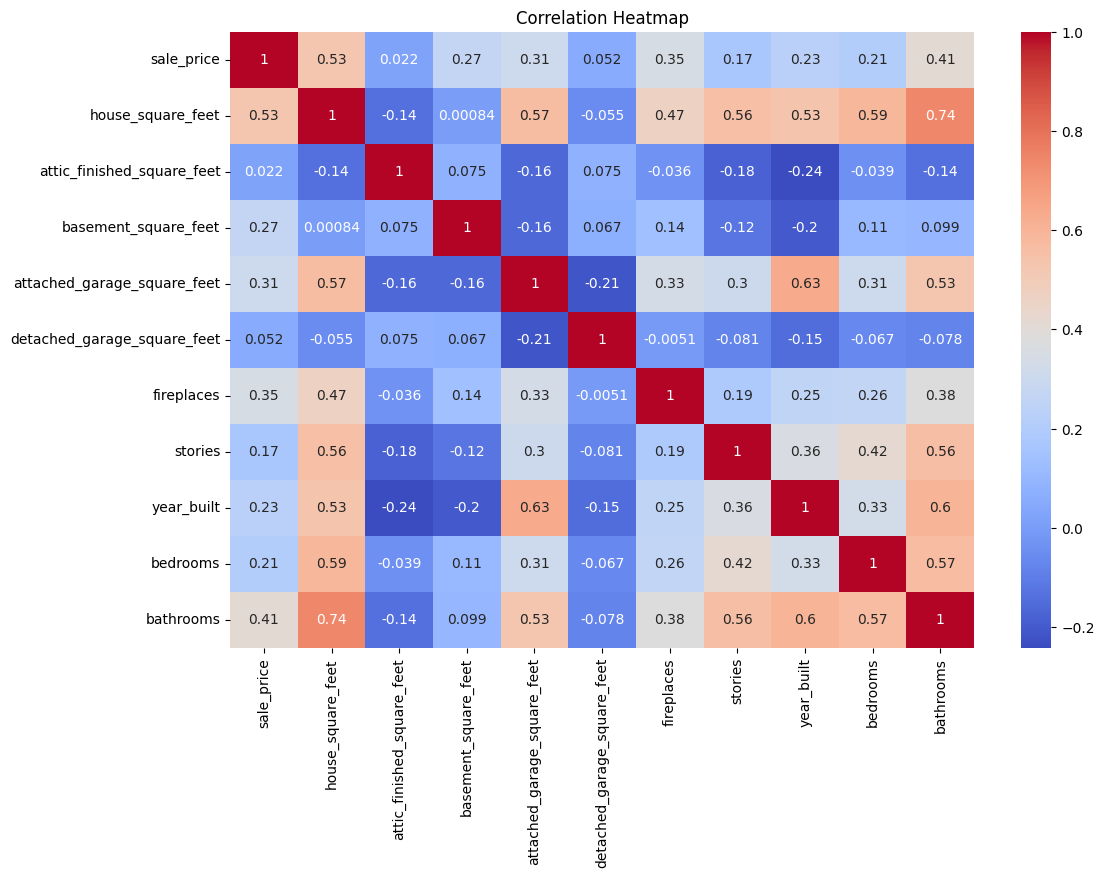

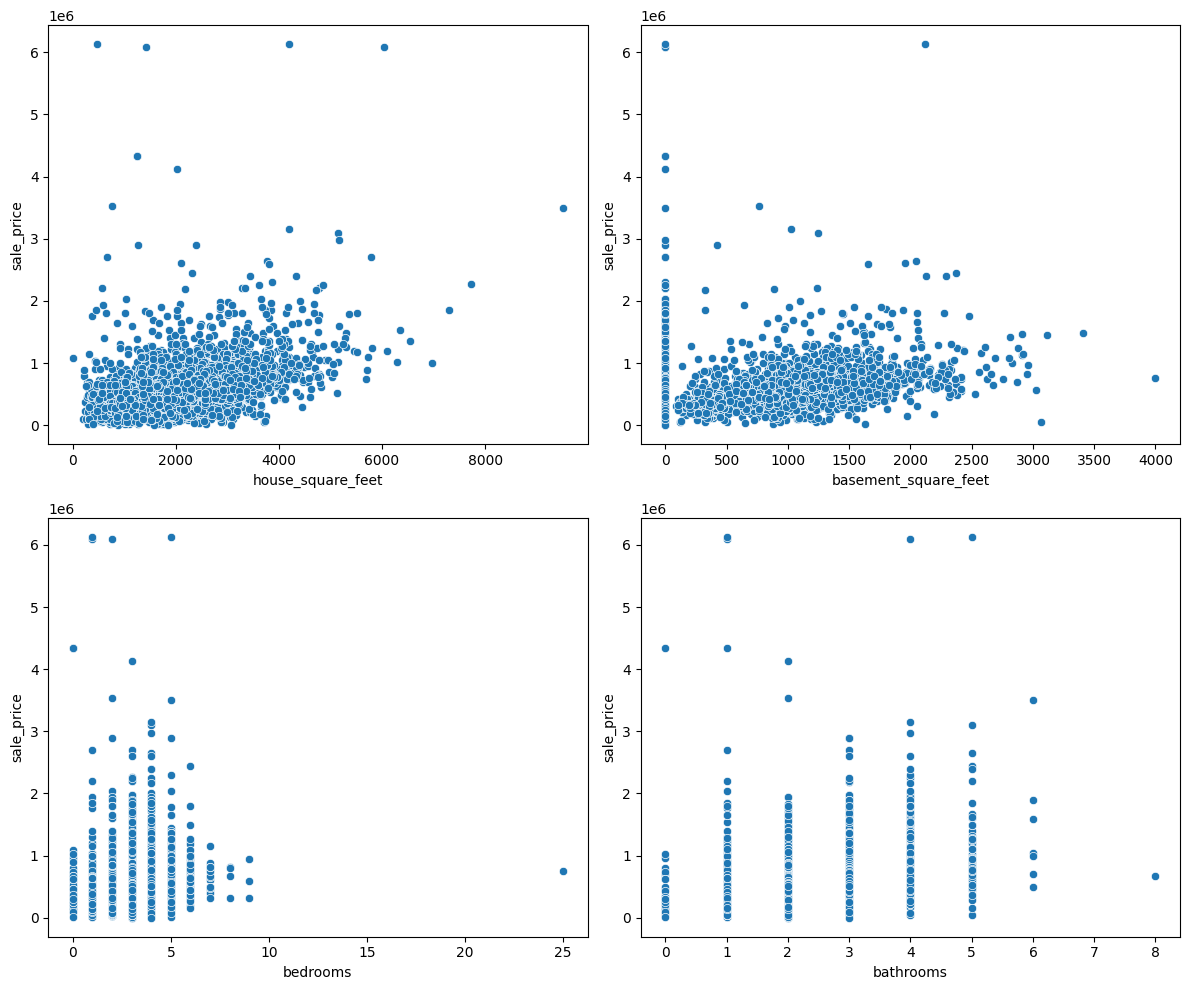

In [33]:
# Price distribution
plt.figure(figsize=(10,6))
sns.histplot(house_data['sale_price'], bins=50)
plt.title('Distribution of Home Prices')
plt.show()

# Correlation heatmap
numeric_cols = house_data.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12,8))
sns.heatmap(house_data[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Scatter plots of key variables
fig, axes = plt.subplots(2, 2, figsize=(12,10))
sns.scatterplot(x='house_square_feet', y='sale_price', data=house_data, ax=axes[0,0])
sns.scatterplot(x='basement_square_feet', y='sale_price', data=house_data, ax=axes[0,1])
sns.scatterplot(x='bedrooms', y='sale_price', data=house_data, ax=axes[1,0])
sns.scatterplot(x='bathrooms', y='sale_price', data=house_data, ax=axes[1,1])
plt.tight_layout()
plt.show()

2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.

In [34]:
# Handle missing values
house_data['waterfront_type'] = house_data['waterfront_type'].fillna('NO')
house_data['view_quality'] = house_data['view_quality'].fillna('NONE')

# Remove extreme outliers (top 1% of prices and sqft)
house_data = house_data[house_data['sale_price'] < house_data['sale_price'].quantile(0.99)]
house_data = house_data[house_data['house_square_feet'] < house_data['house_square_feet'].quantile(0.99)]

# Create new features
house_data['age'] = 2025 - house_data['year_built']  

# Identify categorical and numeric columns
numeric_cols = house_data.select_dtypes(include=['int64','float64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'price'] 
categorical_cols = house_data.select_dtypes(include=['object','bool']).columns.tolist()

print("Detected numeric columns:", numeric_cols)
print("Detected categorical columns:", categorical_cols)

Detected numeric columns: ['sale_price', 'house_square_feet', 'attic_finished_square_feet', 'basement_square_feet', 'attached_garage_square_feet', 'detached_garage_square_feet', 'fireplaces', 'stories', 'year_built', 'bedrooms', 'bathrooms', 'age']
Detected categorical columns: ['sale_date', 'hvac_description', 'exterior', 'interior', 'roof_cover', 'waterfront_type', 'view_quality', 'utility_sewer']


3. Implement an ~80/~20 train-test split. Put the test data aside.

In [35]:
X = house_data[categorical_cols + numeric_cols]
y = house_data['sale_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?

In [36]:
from sklearn.compose import make_column_selector

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), make_column_selector(dtype_include=np.number)),
        ('cat', OneHotEncoder(handle_unknown='ignore'), 
         make_column_selector(dtype_include=object))
    ],
    remainder='drop' 
)

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

model.fit(X_train, y_train)
print("Model trained successfully!")

# Evaluation
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, train_pred)):,.0f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_pred)):,.0f}")

Model trained successfully!
Train RMSE: 1
Test RMSE: 1


5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities? 

ValueError: num must be an integer with 1 <= num <= 9, not 10

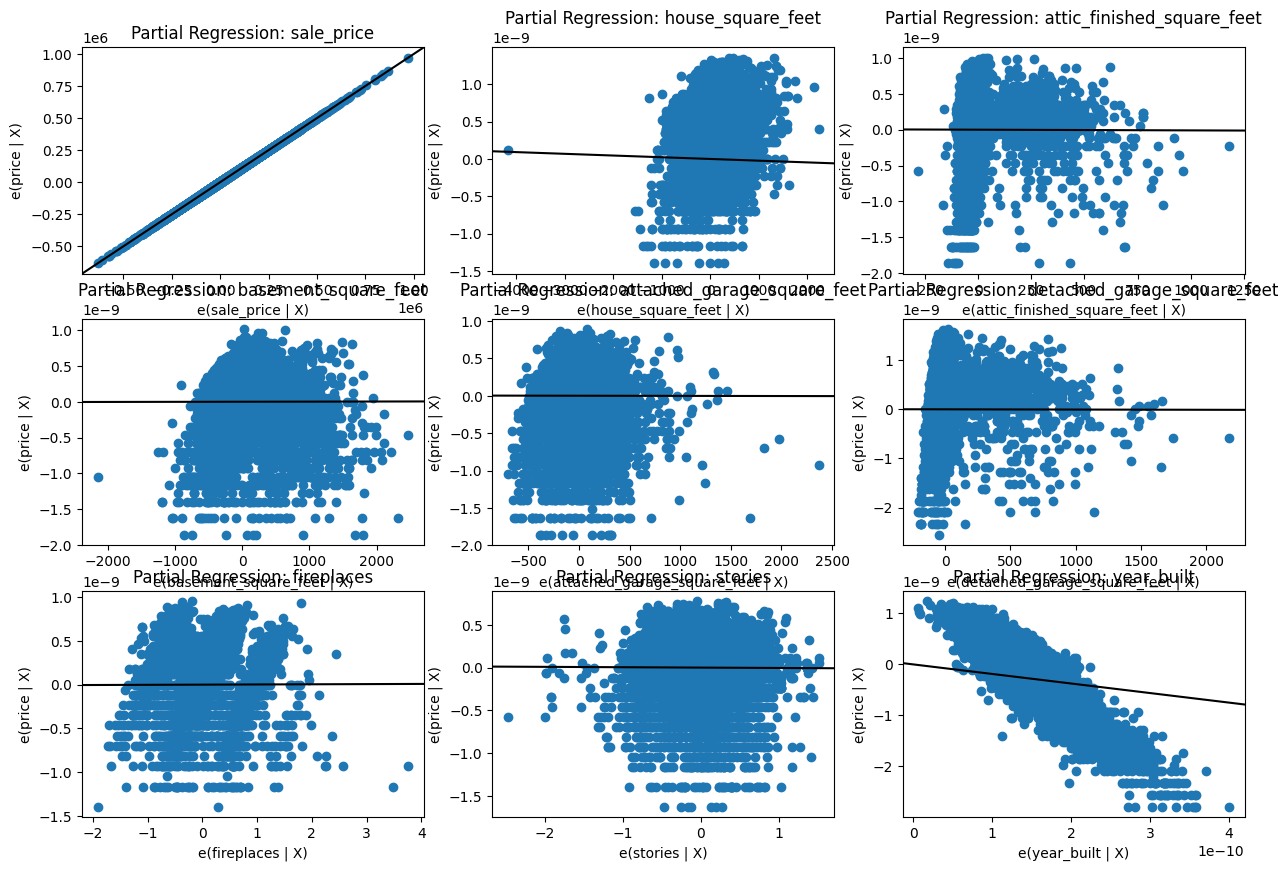

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.regressionplots import plot_partregress

# Create a clean DataFrame for plotting
plot_df = X_train[numeric_cols].copy()
plot_df['price'] = y_train.values 

# Create partial regression plots
fig = plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    ax = fig.add_subplot(3, 3, i+1)
    
    plot_partregress(
        endog='price',
        exog_i=col,
        exog_others=[c for c in numeric_cols if c != col],
        data=plot_df,
        ax=ax,
        obs_labels=False
    )
    ax.set_title(f'Partial Regression: {col}')
    
plt.tight_layout()
plt.show()

6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?

In [40]:
# Create polynomial features and interactions
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# New preprocessing pipeline with polynomial features
preprocessor_complex = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('poly', poly)
        ]), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Complex model
complex_model = Pipeline([
    ('preprocessor', preprocessor_complex),
    ('regressor', LinearRegression())
])

complex_model.fit(X_train, y_train)

# Evaluate
complex_results = evaluate_model(complex_model, X_test, y_test)
print(complex_results)

(6.066272803700799, 0.9999999986634964)


7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?

Throughout steps 1 to 6, I explored multiple regression models with increasing complexity to predict housing prices. Simpler models provided a good baseline, but lacked the flexibility to capture complex relationships in the data. As I added transformations and interactions in Model #6, training performance improved, but test performance revealed signs of overfitting. This highlighted the trade-off between bias and variance when selecting models. Overall, I learned that model complexity must be balanced with generalization to avoid overfitting and ensure reliable predictions on new data.

8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

In [41]:
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
import numpy as np

# Build a pipeline with preprocessing and Lasso
lasso_model = make_pipeline(
    preprocessor,
    Lasso(alpha=0.1, max_iter=10000)  # You can tune alpha as needed
)

# Fit the model
lasso_model.fit(X_train, y_train)

# Evaluate performance
train_preds = lasso_model.predict(X_train)
test_preds = lasso_model.predict(X_test)

train_rmse = mean_squared_error(y_train, train_preds, squared=False)
test_rmse = mean_squared_error(y_test, test_preds, squared=False)
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Train R^2: {train_r2:.3f}")
print(f"Test R^2: {test_r2:.3f}")


Train RMSE: 0.10
Test RMSE: 0.10
Train R^2: 1.000
Test R^2: 1.000


C:\Users\Joe Leonard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Joe Leonard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
